In [1]:
import numpy as np
from tensorflow.keras import datasets, layers, models, Model
import tensorflow.keras.backend as K

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [2]:
def preprocess(imgs):
    # Convert image pixel values to float32 and normalize to the range [0, 1]
    imgs = imgs.astype("float32") / 255.0

    # Pad each image with 2 pixels of zeros on all sides
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

    # Add an extra dimension at the end to represent a single color channel
    imgs = np.expand_dims(imgs, -1)

    # Return the preprocessed images
    return imgs

# Apply preprocessing to the training and test datasets
x_train = preprocess(x_train)
x_test = preprocess(x_test)


#The Autoencoder Architecture
#An autoencoder is a neural network made up of two parts:
#• An encoder network that compresses high-dimensional input data such as an
#image into a lower-dimensional embedding vector
#• A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)

#In an autoencoder, the encoder’s job is to take the input image and map it to an embedding vector in the latent space.

#To achieve this, we first create an Input layer for the image and pass this through
#three Conv2D layers in sequence, each capturing increasingly high-level features. We
#use a stride of 2 to halve the size of the output of each layer, while increasing the
#number of channels. The last convolutional layer is flattened and connected to a
#Dense layer of size 2, which represents our two-dimensional latent space.

#Let’s first define what we mean by an embedding. The embedding (z) is a compression of the original image into a lower-dimensional latent space. The idea is that by choosing any point in the latent space, we can generate novel images by passing this point through the decoder since the decoder has learned how to convert points in the latent space into viable images.

In [17]:
# Define the input layer for the encoder with shape (32, 32, 1)
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")

# Add a Conv2D layer with 32 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding="same")(encoder_input)

# Add a Conv2D layer with 64 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding="same")(x)

# Add a Conv2D layer with 128 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding="same")(x)

# Capture the shape of the tensor before flattening for future use
shape_before_flattening = K.int_shape(x)[1:]

# Flatten the output of the last Conv2D layer
x = layers.Flatten()(x)

# Add a Dense layer with 2 units for the encoder output
encoder_output = layers.Dense(2, name="encoder_output")(x)

# Create the encoder model by specifying the input and output layers
encoder = models.Model(encoder_input, encoder_output)


#The Decoder
#The decoder is a mirror image of the encoder—instead of convolutional layers, we
#use convolutional transpose layers,

#In Keras, the Conv2DTranspose layer allows us to perform convolutional transpose
#operations on tensors. By stacking these layers, we can gradually expand the size of
#each layer, using strides of 2, until we get back to the original image dimension of
# 32 × 32.

In [23]:
# Define the input layer for the decoder with shape (2,) (the embedding)
decoder_input = layers.Input(shape=(2,), name="decoder_input")

# Add a Dense layer to match the shape before flattening 
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) #Connect the input to a Dense layer.

# Reshape the tensor to the captured shape before flattening
x = layers.Reshape(shape_before_flattening)(x)  #Reshape this vector into a tensor that can be fed as input into the first Conv2DTranspose layer.

# Add a Conv2DTranspose layer with 128 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding="same")(x)  #Stack Conv2DTranspose layers on top of each other.

# Add a Conv2DTranspose layer with 64 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding="same")(x)

# Add a Conv2DTranspose layer with 32 filters, kernel size 3x3, stride 2, ReLU activation, and same padding
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding="same")(x)

# Add the final Conv2D layer with 1 filter, kernel size 3x3, stride 1, sigmoid activation, and same padding
decoder_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

# Create the decoder model by specifying the input and output layers
decoder = models.Model(decoder_input, decoder_output)  #The Keras Model that defines the decoder—a model that takes an embedding in the latent space and decodes it into the original image domain.


#joining the encoder and decoder
#to train the encoder and decoder simultaneously, we need to define a model that will represent the flow of an image through the encoder
#and back out through the decoder. 


In [27]:
# Create the full autoencoder model by connecting the encoder input to the decoder output through the encoder output
autoencoder_input = layers.Input(shape=(32, 32, 1), name="autoencoder_input")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img)

# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Fit the autoencoder model to the training data
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 0.3604 - val_loss: 0.2601
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.2581 - val_loss: 0.2571
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.2541 - val_loss: 0.2534
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.2520 - val_loss: 0.2525
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.2498 - val_loss: 0.2515


In [29]:
# Reconstructing images using the autoencoder
example_images = x_test[:5000]

# Predict the reconstructed images using the autoencoder
predictions = autoencoder.predict(example_images)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


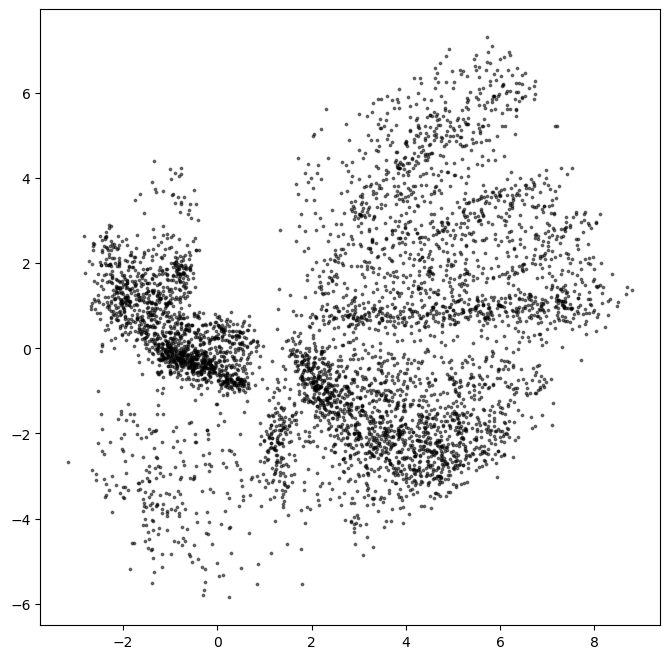

In [33]:
#We can visualize how images are embedded into the latent space by passing the test set through the encoder and plotting the resulting embeddings


import matplotlib.pyplot as plt
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


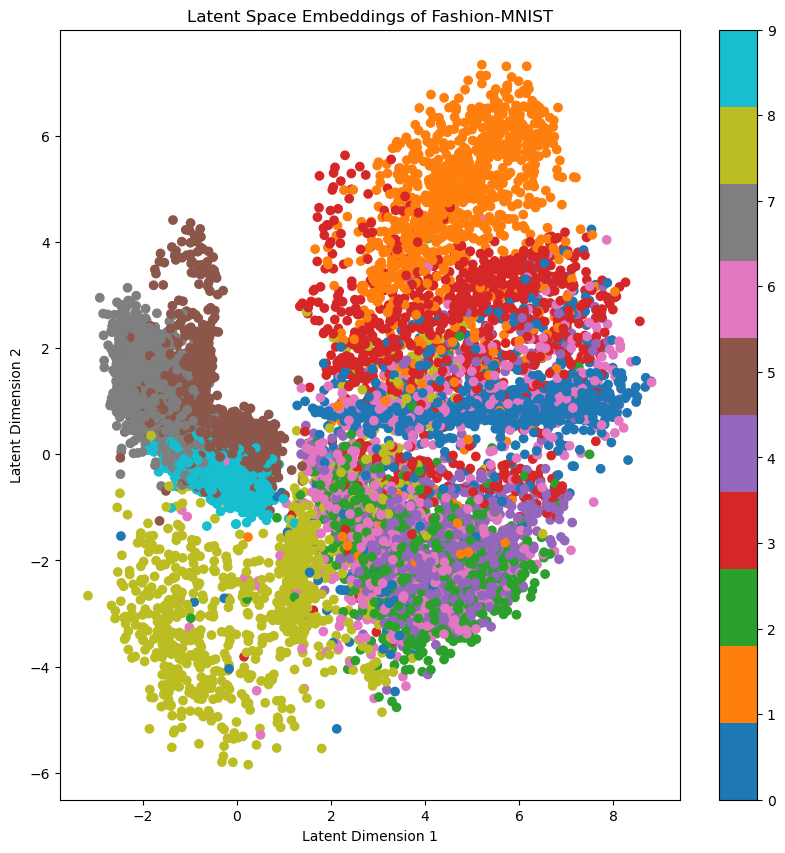

In [35]:
# Use the encoder to transform the test images to the latent space
latent_space_embeddings = encoder.predict(x_test)

# Define the labels for the test images
labels = y_test

# Plot the embeddings in the latent space
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_space_embeddings[:, 0], latent_space_embeddings[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Embeddings of Fashion-MNIST')
plt.show()

#Now the structure becomes very clear! Even though the clothing labels were never shown to the model during training, the autoencoder has naturally grouped items that look alike into the same parts of the latent space. For example, the dark blue cloud of points in the bottom-right corner of the latent space are all different images of trousers and the red cloud of points toward the center are all ankle boots.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


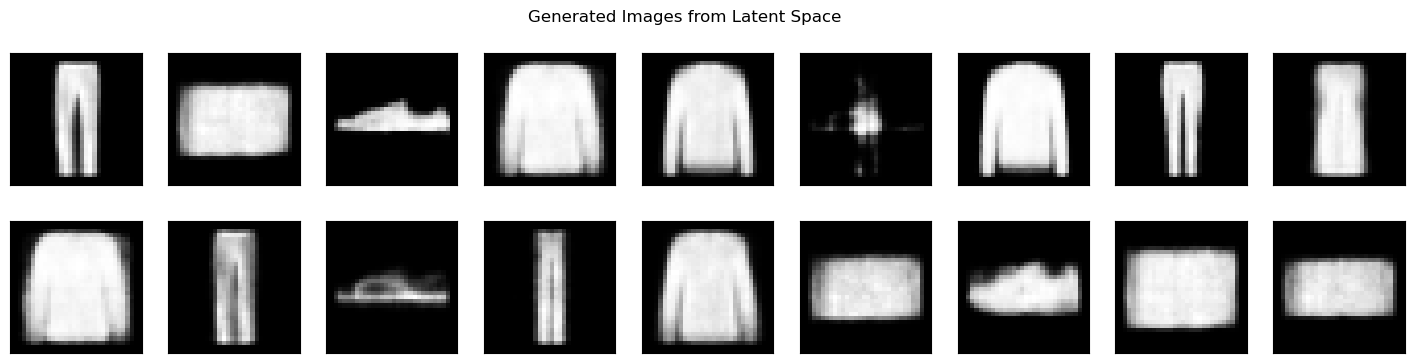

In [41]:
#GEnerating new images

# Define the minimum and maximum values of the latent space embeddings
mins, maxs = np.min(latent_space_embeddings, axis=0), np.max(latent_space_embeddings, axis=0)

# Sample 18 points uniformly within the latent space
sample_points = np.random.uniform(mins, maxs, size=(18, 2))

# Use the decoder to generate images from the sampled points
generated_images = decoder.predict(sample_points)

# Visualize the generated images
plt.figure(figsize=(18, 4))
for i in range(18):
    # Display generated image
    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(generated_images[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Generated Images from Latent Space')
plt.show()

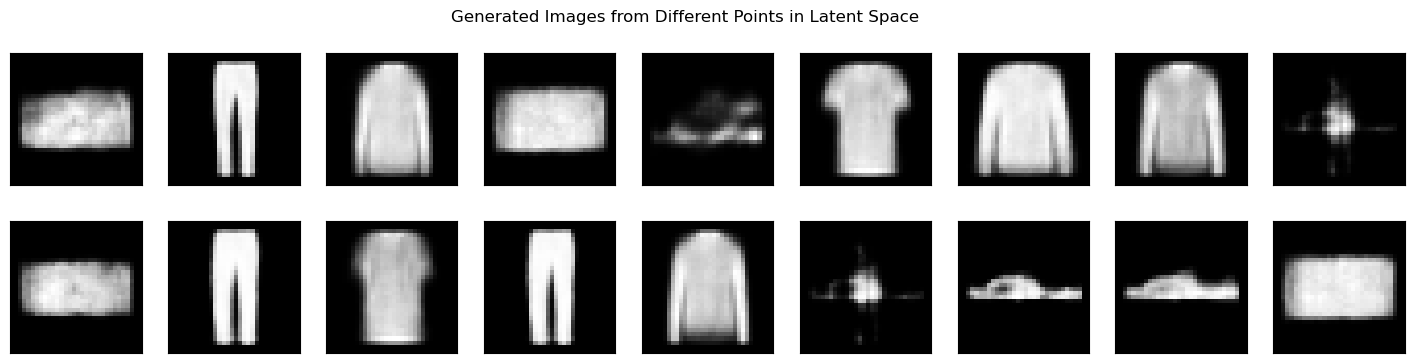

In [45]:
# Visualize the generated images
plt.figure(figsize=(18, 4))
for i in range(num_points):
    # Display generated image
    ax = plt.subplot(2, num_points // 2, i + 1)
    plt.imshow(generated_images[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Generated Images from Different Points in Latent Space')
plt.show()

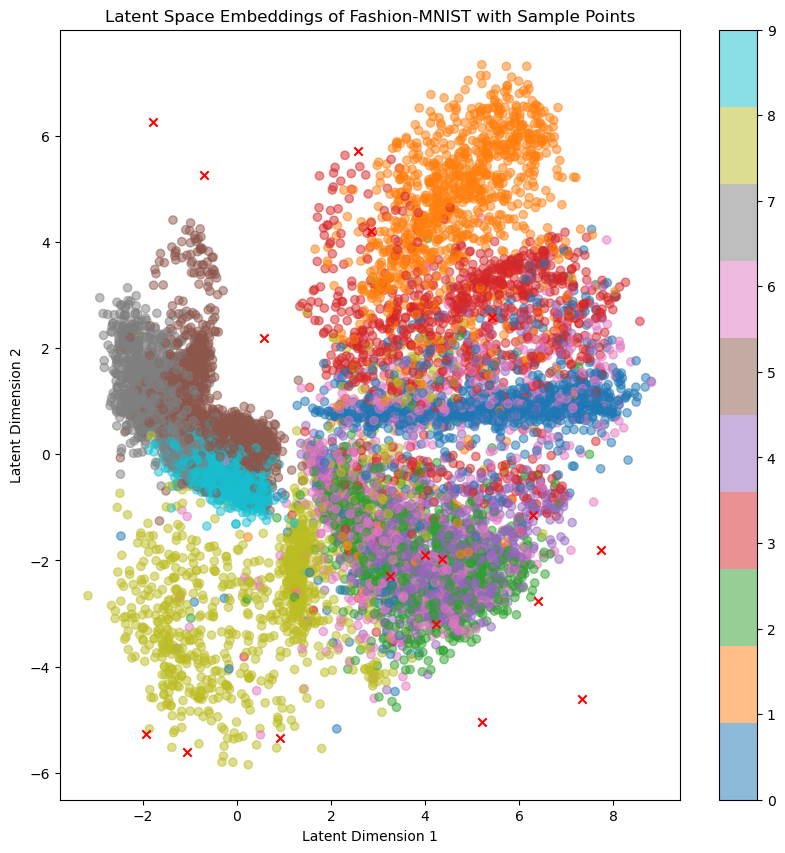

In [51]:
# Plot the embeddings in the latent space
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_space_embeddings[:, 0], latent_space_embeddings[:, 1], c=y_test, cmap='tab10', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.scatter(sample_points[:, 0], sample_points[:, 1], c='red', marker='x')  # Highlight sampled points
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Embeddings of Fashion-MNIST with Sample Points')
plt.show()


#Each bl dot maps to one of the images shown on the right of the diagram, with the
#embedding vector shown underneath.

In [55]:
#The distribution of clothing items in the latent space is uneven, with some items represented over a much larger area than others. The distribution is asymmetrical, with a notable bias towards positive y-axis values, and some points extending beyond y-axis values greater than 8. Additionally, large gaps exist between clusters of points, making it challenging to sample from the latent space effectively. To better understand and visualize this, we can overlay the latent space with a grid of decoded images, highlighting these disparities and aiding in the interpretation of the latent structure

In [57]:
#When uniformly sampling points in a bounded latent space, items like bags (ID 8) are more likely to be generated than ankle boots (ID 9) due to their larger representation area. The undefined distribution of points in the latent space complicates random point selection, as theoretically any point in the 2D plane is valid, with no guarantee of centrality around (0, 0). This sampling challenge is further exacerbated by holes in the latent space, where no original images are encoded, particularly at the domain edges, leading to unrecognizable decodings. Even central points may not consistently decode into well-formed images due to the lack of continuity enforcement in the autoencoder, causing discrepancies like (–1, –1) decoding satisfactorily while (–1.1, –1.1) does not. This issue is subtle in two dimensions but becomes more pronounced with higher-dimensional latent spaces needed for complex images like faces, resulting in large gaps between groups of similar points without any mechanism to ensure the generation of coherent images from these spaces.

In [59]:
#In order to solve these three problems, we need to convert our autoencoder into a
#variational autoencoder.

In [61]:
#The two parts that we need to change are the encoder and the loss function.

In [65]:
#In a regular autoencoder, each image is mapped to a single specific point in the latent space. In contrast, a variational autoencoder maps each image to a distribution of points, forming a multivariate normal distribution around a central point in the latent space.

#A normal distribution, also known as a Gaussian distribution, is a probability distribution that forms a bell-shaped curve. This curve is defined by two main parameters: the mean (μ), which is the central point, and the variance (σ²), which measures how spread out the values are. The standard deviation (σ) is simply the square root of the variance, indicating the average distance of the values from the mean.

#The probability density function of a normal distribution in one dimension describes how likely it is to find a value within a specific range. It is given by:

#This function tells us the probability of a value  (𝑥 occurring in a normal distribution with mean μ and variance  𝜎2)


#Previously, we observed that in a standard autoencoder, the latent space doesn't need to be continuous. This means that even if a point like (–2, 2) decodes to a well-formed image of a sandal, a nearby point like (–2.1, 2.1) might not produce a similar image. In a variational autoencoder (VAE), however, we sample a random point from an area around a central point (z_mean) in the latent space. This forces the decoder to ensure that all points in the same neighborhood produce similar images when decoded, keeping the reconstruction loss low. This characteristic is beneficial because it means that even if we choose a point in the latent space that the decoder hasn't seen before, it will likely still decode into a well-formed image.



In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

class Sampling(layers.Layer):
    def call(self, inputs):
        """
        Reparameterization trick: samples a point z from the latent space
        given the mean and log variance.
        
        Args:
            inputs (tuple): a tuple (z_mean, z_log_var) of the mean and log variance of the latent space.

        Returns:
            z (tensor): a sampled point in the latent space.
        """
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]  # Get the batch size
        dim = tf.shape(z_mean)[1]    # Get the dimensionality of the latent space
        epsilon = K.random_normal(shape=(batch, dim))  # Sample from a standard normal distribution
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Reparameterization trick

# Define the input layer for the encoder with shape (32, 32, 1)
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")

# Add Conv2D layers to the encoder
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# Capture the shape of the tensor before flattening for future use
shape_before_flattening = K.int_shape(x)[1:]

# Flatten the output of the last Conv2D layer
x = layers.Flatten()(x)

# Add Dense layers to output the mean and log variance for the latent space
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)

# Use the Sampling layer to sample a point z from the latent space
z = Sampling()([z_mean, z_log_var])

# Create the encoder model by specifying the input and output layers
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Print the summary of the encoder model
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#The code defines an encoder model for a variational autoencoder. It starts with an input layer for images of shape (32, 32, 1) and passes the input through three convolutional layers, each halving the spatial dimensions and increasing the number of filters. The shape before flattening is captured for future use, and the tensor is then flattened. Two dense layers output the mean (z_mean) and log variance (z_log_var) of the latent space. A custom Sampling layer performs the reparameterization trick to sample a point (z) from the latent space based on z_mean and z_log_var. Finally, the encoder model is created with the input layer and the outputs [z_mean, z_log_var, z], and its summary is printed to display the model architecture.

In [71]:
# The reparameterization trick is a technique used in variational autoencoders to enable gradient-based optimization of the model despite the stochastic nature of sampling from the latent space. Instead of directly sampling from a distribution defined by the mean and variance, the trick involves sampling from a standard normal distribution and then transforming the sample using the mean and variance. Specifically, a point z is generated by adding the mean (z_mean) to the product of the standard deviation (derived from z_log_var) and a random variable epsilon sampled from a standard normal distribution. This transformation allows the model to be differentiable with respect to the mean and variance, thus enabling backpropagation and efficient training using gradient descent methods.

In [73]:
#In a variational autoencoder (VAE), the loss function consists of two components: the reconstruction loss, which measures the difference between the original images and their reconstructions, and the Kullback–Leibler (KL) divergence term. The KL divergence measures how much the distribution defined by z_mean and z_log_var deviates from a standard normal distribution. The KL loss is calculated as kl_loss = -0.5 * sum(1 + z_log_var - z_mean^2 - exp(z_log_var)), and it penalizes the network for deviations from z_mean = 0 and z_log_var = 0. This term encourages the latent space to follow a standard normal distribution, ensuring better generalization and smoother interpolation in the latent space.

In [75]:
#The addition of the KL divergence term to the loss function in a VAE helps by providing a well-defined distribution, the standard normal distribution, for sampling points in the latent space. This term encourages the encoded distributions to be centered around the origin, reducing the likelihood of large gaps between clusters of points and ensuring that the latent space is used symmetrically and efficiently. In the original VAE formulation, the loss function is the sum of the reconstruction loss and the KL divergence. A variant, the β-VAE, introduces a weighting factor for the KL divergence to balance it with the reconstruction loss. If the reconstruction loss is weighted too heavily, the regulatory effect of the KL divergence is diminished, leading to issues similar to those in plain autoencoders. Conversely, if the KL divergence is weighted too heavily, the reconstructed images may be poor. Thus, tuning the weighting factor is crucial for optimal VAE performance.

In [95]:
#Analysis of the Variational Autoencoder
#Now that we have trained our VAE, we can use the encoder to encode the images in
#the test set and plot the z_mean values in the latent space. We can also sample from a
#standard normal distribution to generate points in the latent space and use the
#decoder to decode these points back into pixel space to see how the VAE performs

In [98]:


# Define the VAE model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder  # Initialize the encoder
        self.decoder = decoder  # Initialize the decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")  # Track total loss
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")  # Track reconstruction loss
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")  # Track KL divergence loss

    @property
    def metrics(self):
        # Return a list of metrics to be tracked
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Forward pass: encode the inputs to latent space and decode them back
        z_mean, z_log_var, z = self.encoder(inputs)  # Get the mean, log variance, and sampled z from the encoder
        reconstruction = self.decoder(z)  # Reconstruct the input from the sampled z
        return z_mean, z_log_var, reconstruction  # Return the mean, log variance, and reconstruction

    def train_step(self, data):
        # Custom training step
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)  # Forward pass
            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                500 * losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
            # Calculate KL divergence loss
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss  # Total loss
        grads = tape.gradient(total_loss, self.trainable_weights)  # Compute gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # Apply gradients
        self.total_loss_tracker.update_state(total_loss)  # Update total loss
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)  # Update reconstruction loss
        self.kl_loss_tracker.update_state(kl_loss)  # Update KL divergence loss
        return {m.name: m.result() for m in self.metrics}  # Return the tracked metrics

# Instantiate the VAE model with the encoder and decoder
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")  # Compile the model with the Adam optimizer

# Load the training dataset (replace 'train' with actual dataset variable)
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)

# Resize images to (32, 32, 1)
x_train = tf.image.resize(x_train, (32, 32))

# Fit the VAE model to the training data
vae.fit(
    x_train,  # Training data
    epochs=5,  # Number of epochs
    batch_size=100  # Batch size
)


Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - kl_loss: 5.3711 - reconstruction_loss: 169.3711 - total_loss: 174.7423
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - kl_loss: 5.4246 - reconstruction_loss: 168.8430 - total_loss: 174.2675
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - kl_loss: 5.4926 - reconstruction_loss: 168.1232 - total_loss: 173.6158
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - kl_loss: 5.4923 - reconstruction_loss: 167.7115 - total_loss: 173.2039
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - kl_loss: 5.4988 - reconstruction_loss: 167.3111 - total_loss: 172.8098


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


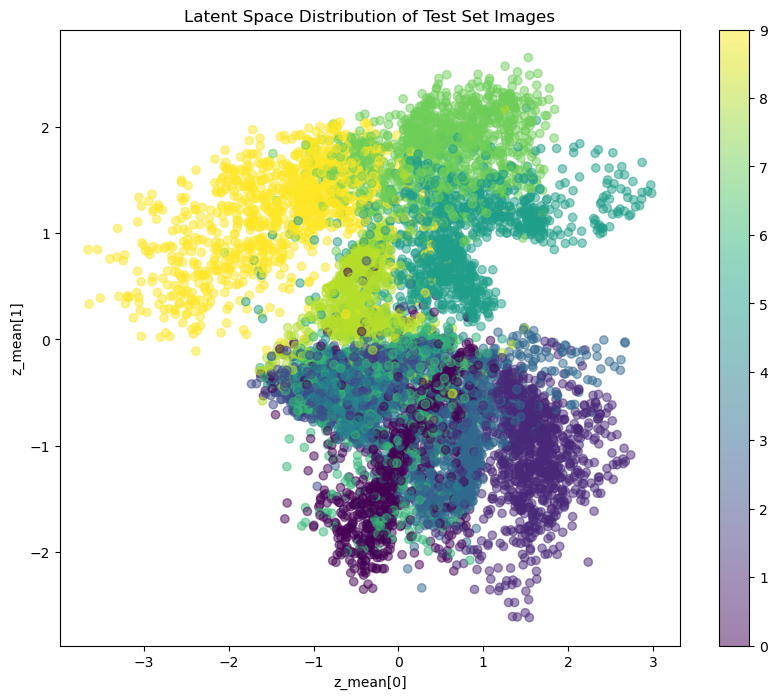

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


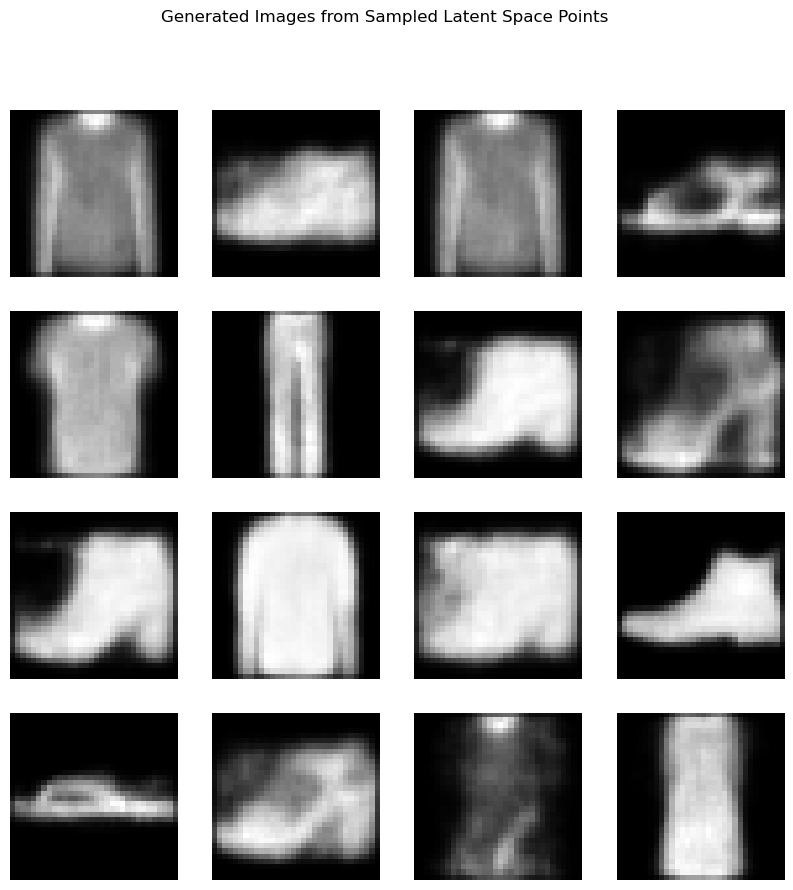

In [100]:
# Encode the test set images
_, (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)
x_test = tf.image.resize(x_test, (32, 32))

# Get the mean values of the latent space for the test set images
z_mean, _, _ = vae.encoder.predict(x_test)

# Plot the z_mean values in the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.title("Latent Space Distribution of Test Set Images")
plt.show()

# Generate new images from the latent space
num_samples = 16  # Number of images to generate
latent_dim = z_mean.shape[1]

# Sample points from a standard normal distribution
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))

# Decode the sampled points to generate new images
generated_images = vae.decoder.predict(random_latent_vectors)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].reshape(32, 32), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Images from Sampled Latent Space Points")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


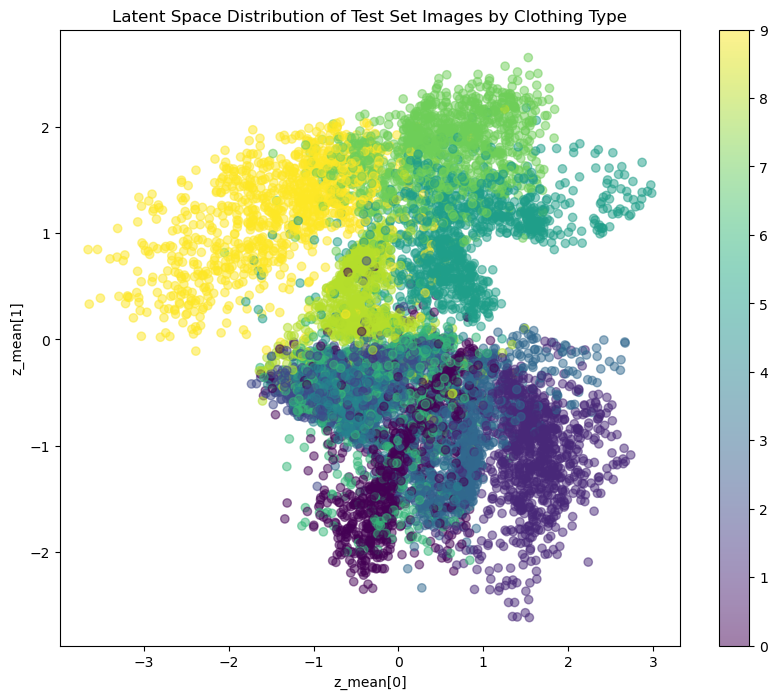

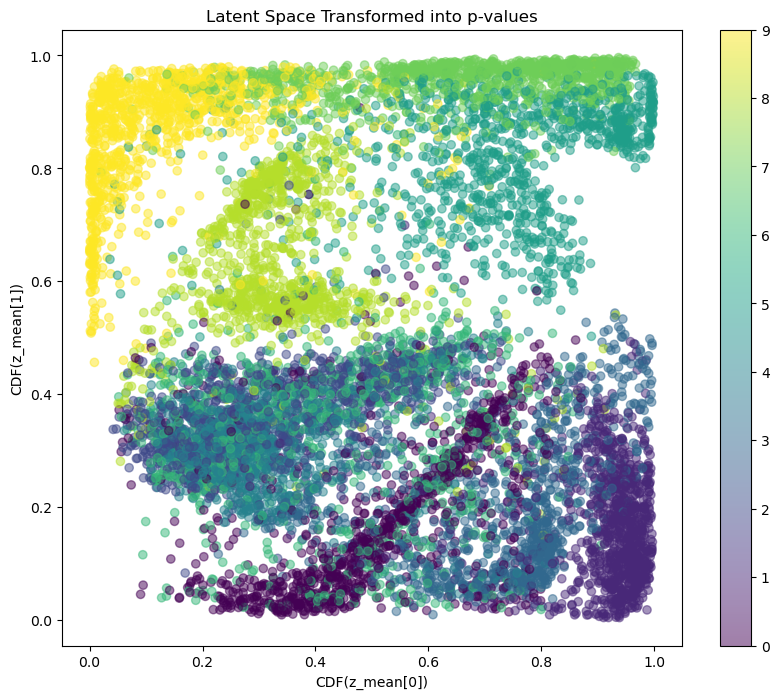

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


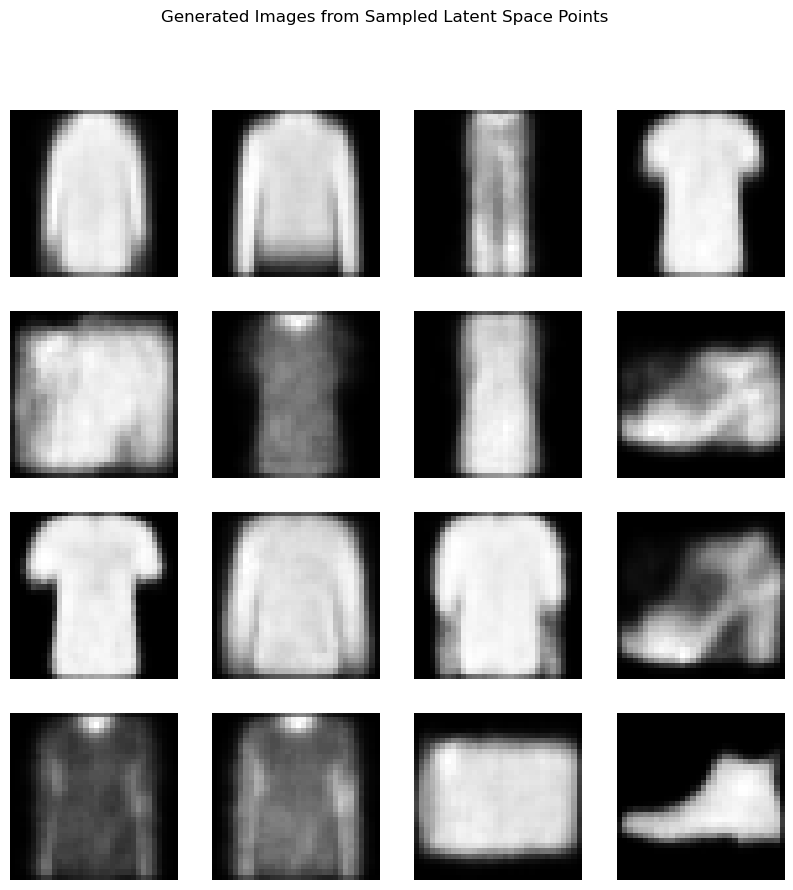

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the test dataset and preprocess it
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)
x_test = tf.image.resize(x_test, (32, 32))

# Encode the test images to the latent space
z_mean, z_log_var, _ = vae.encoder.predict(x_test)

# Plot the z_mean values in the latent space, colored by clothing type
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.title("Latent Space Distribution of Test Set Images by Clothing Type")
plt.show()

# Transform the space into p-values
# Compute the cumulative distribution function (CDF) for each z_mean
z_mean_cdf = norm.cdf(z_mean)

# Plot the transformed space into p-values
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean_cdf[:, 0], z_mean_cdf[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.xlabel("CDF(z_mean[0])")
plt.ylabel("CDF(z_mean[1])")
plt.title("Latent Space Transformed into p-values")
plt.show()

# Sample from the standard normal distribution to generate points in the latent space
num_samples = 16
latent_dim = z_mean.shape[1]
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))

# Decode the sampled points to generate new images
generated_images = vae.decoder.predict(random_latent_vectors)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].reshape(32, 32), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated Images from Sampled Latent Space Points")
plt.show()
